# Introduction to JaxNRSur

This notebook demonstrates the basic usage of the JaxNRSur package for generating and analyzing gravitational waveforms using JAX. Each section is explained with comments and markdown to help you understand the workflow and the purpose of each code cell.

## Importing Libraries

First, we import the required libraries: JAX for numerical computing, Equinox for model differentiation, matplotlib for plotting, and the JaxNRSur surrogate model. This sets up the environment for the rest of the notebook.

In [1]:
import equinox as eqx
import jax.numpy as jnp
from jaxnrsur.NRHybSur3dq8 import NRHybSur3dq8Model
import matplotlib.pyplot as plt
import jax

%matplotlib inline

jax.config.update("jax_enable_x64", True)  # Use double precision

## Setting Up the Model and Parameters

Next, we define the time array for the waveform, specify the physical parameters (such as mass ratio and spins), and instantiate the NRHybSur3dq8 surrogate model. This prepares everything needed to generate a gravitational waveform.

In [2]:
time = jnp.linspace(-1000, 100, 100000)
params = jnp.array([1.1, 0.1, 0.1])
model = NRHybSur3dq8Model()

Try loading file from cache
Cache found and loading data


## Generating and Plotting the Waveform

We use the surrogate model to generate the gravitational waveform for the specified parameters and time array. Note that the waveform shown is in geometric units, meaning it does not have the mass scaling or other extrinsic factors applied.

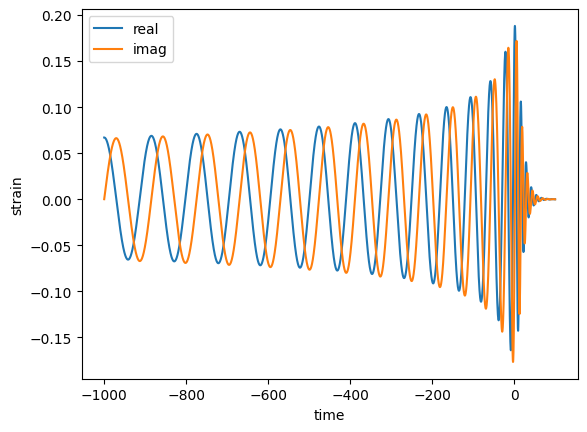

In [3]:
h = model.get_waveform_geometric(time, params)
# Plot the waveform
plt.plot(time, h[0], label="real")
plt.plot(time, h[1], label="imag")
plt.xlabel("time")
plt.ylabel("strain")
plt.legend()
plt.show()

## Computing Gradients with JAX

JaxNRSur models are fully differentiable. Here, we define a function to sum the real part of the waveform and use JAX's automatic differentiation (via Equinox) to compute gradients with respect to the input parameters. This is useful for optimization and parameter estimation tasks.

In [4]:
# Compute the gradient of the waveform with respect to the parameters
def sum_f(params):
    return jnp.sum(model.get_waveform_geometric(time, params)[0])


grad_f = eqx.filter_jit(eqx.filter_grad(sum_f))
grad_f(params)

Array([ -0.6704086 , 154.92167921, -18.88196183], dtype=float64)

## Vectorized Waveform Computation

By using JAX's `vmap` functionality, we can efficiently compute waveforms for multiple sets of parameters in parallel. This is especially useful for large-scale analyses or parameter studies, as it leverages JAX's ability to batch computations.

In [5]:
# Vmap the waveform to compute the waveform for multiple parameters
params_multi = jnp.array([[1.1, 0.1, 0.1]])
params_multi = jnp.repeat(params_multi, 10, axis=0)
h_multi = eqx.filter_jit(
    eqx.filter_vmap(model.get_waveform_geometric, in_axes=(None, 0))
)(time, params_multi)

## High level API

So far we have been using the low-level API of JaxNRSur, which is the direct implementation of all the surrogate models. However, we also provide a high-level API which wraps the low-level API and provides an interface that compute the dimensionful time domain and frequency domain waveforms.

In [6]:
# First we import the JaxNRSur class and initialize it with the model we want to use.
from jaxnrsur import JaxNRSur

jaxnrsur = JaxNRSur(model, alpha_window=0.1, segment_length=4.0, sampling_rate=4096)

In [7]:
# On top of the dimensionless waveform parameters such as mass ratio and spin, we also need to provide the dimensionful parameters such as the total mass and the distance to the source in Mpc.
# The dimensionful parameters are Total Mass, Distance, inclination and phase of coalescence.
params_dimensionful = jnp.array([60.0, 400.0, 0.1, 0.2, 1.1, 0.1, 0.1])
h = jaxnrsur.get_waveform_td(time, params_dimensionful)

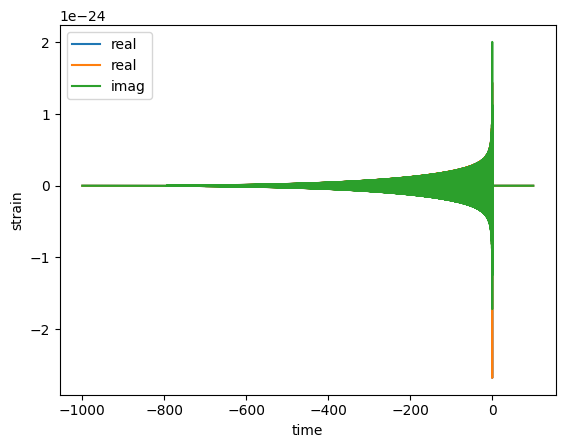

In [8]:
plt.plot(time, h[0], label="real")
# Plot the waveform
plt.plot(time, h[0], label="real")
plt.plot(time, h[1], label="imag")
plt.xlabel("time")
plt.ylabel("strain")
plt.legend()
plt.show()